## Calculate water center of mass coordinates by month

Running unweighted (binary) center of mass, all water classes
Found 378 assets in projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products
Configuration: weighted=False, lowest_DSWE_class=1
------------------------------------------------------------
Processing 1984-06... ✓ Centroid: (22.7525, -19.2176), Area: 8766.7 km²
Processing 1984-07... ✓ Centroid: (22.7557, -19.2241), Area: 8942.8 km²
Processing 1984-09... ✓ Centroid: (22.7993, -19.2504), Area: 7799.9 km²
Processing 1984-10... ✓ Centroid: (22.7886, -19.2462), Area: 7599.8 km²
Processing 1984-11... ✓ Centroid: (22.7855, -19.2373), Area: 7511.8 km²
Processing 1985-04... ✓ Centroid: (22.7040, -19.1385), Area: 5165.2 km²
Processing 1986-11... ✓ Centroid: (22.8021, -19.2156), Area: 6491.2 km²
Processing 1986-12... ✓ Centroid: (22.7942, -19.1954), Area: 5902.3 km²
Processing 1987-01... ✓ Centroid: (22.8003, -19.1973), Area: 6529.5 km²
Processing 1987-02... ✓ Centroid: (22.7850, -19.1559), Area: 5688.5 km²
Proc

Processing 2011-02... ✓ Centroid: (23.1929, -19.4889), Area: 3574.3 km²
Processing 2011-03... ✓ Centroid: (23.1829, -19.4807), Area: 3485.0 km²
Processing 2013-03... ✓ Centroid: (22.7675, -19.1565), Area: 6200.8 km²
Processing 2013-04... ✓ Centroid: (22.7667, -19.1565), Area: 6196.3 km²
Processing 2013-05... ✓ Centroid: (22.7677, -19.1890), Area: 7059.8 km²
Processing 2013-06... ✓ Centroid: (22.7279, -19.1967), Area: 6412.2 km²
Processing 2013-07... ✓ Centroid: (22.7749, -19.2366), Area: 7123.6 km²
Processing 2013-08... ✓ Centroid: (22.7978, -19.2473), Area: 7012.4 km²
Processing 2013-09... ✓ Centroid: (22.7969, -19.2500), Area: 6171.8 km²
Processing 2013-10... ✓ Centroid: (22.8027, -19.2095), Area: 4884.4 km²
Processing 2013-11... ✓ Centroid: (22.8046, -19.1866), Area: 4306.6 km²
Processing 2013-12... ✓ Centroid: (22.8572, -19.2198), Area: 6302.9 km²
Processing 2014-01... ✓ Centroid: (22.8659, -19.1895), Area: 5720.7 km²
Processing 2014-02... ✓ Centroid: (22.8801, -19.2054), Area: 658

Processing 2022-07... ✓ Centroid: (22.7955, -19.1506), Area: 6318.7 km²
Processing 2022-08... ✓ Centroid: (22.8047, -19.1672), Area: 5884.1 km²
Processing 2022-09... ✓ Centroid: (22.8159, -19.1687), Area: 4984.1 km²
Processing 2022-10... ✓ Centroid: (22.8263, -19.1502), Area: 3756.3 km²
Processing 2022-11... ✓ Centroid: (22.8356, -19.1236), Area: 3529.1 km²
Processing 2022-12... ✓ Centroid: (22.8692, -19.1161), Area: 3865.9 km²
Processing 2023-01... ✓ Centroid: (22.8692, -19.0967), Area: 4679.0 km²
Processing 2023-02... ✓ Centroid: (22.8728, -19.1237), Area: 5423.0 km²
Processing 2023-03... ✓ Centroid: (22.8672, -19.1332), Area: 5613.4 km²
Processing 2023-04... ✓ Centroid: (22.8576, -19.1289), Area: 5989.5 km²
Processing 2023-05... ✓ Centroid: (22.7920, -19.0702), Area: 5065.0 km²
Processing 2023-06... ✓ Centroid: (22.7494, -19.0806), Area: 5117.2 km²
Processing 2023-07... ✓ Centroid: (22.7364, -19.0762), Area: 4868.4 km²
Processing 2023-08... ✓ Centroid: (22.7466, -19.0892), Area: 447

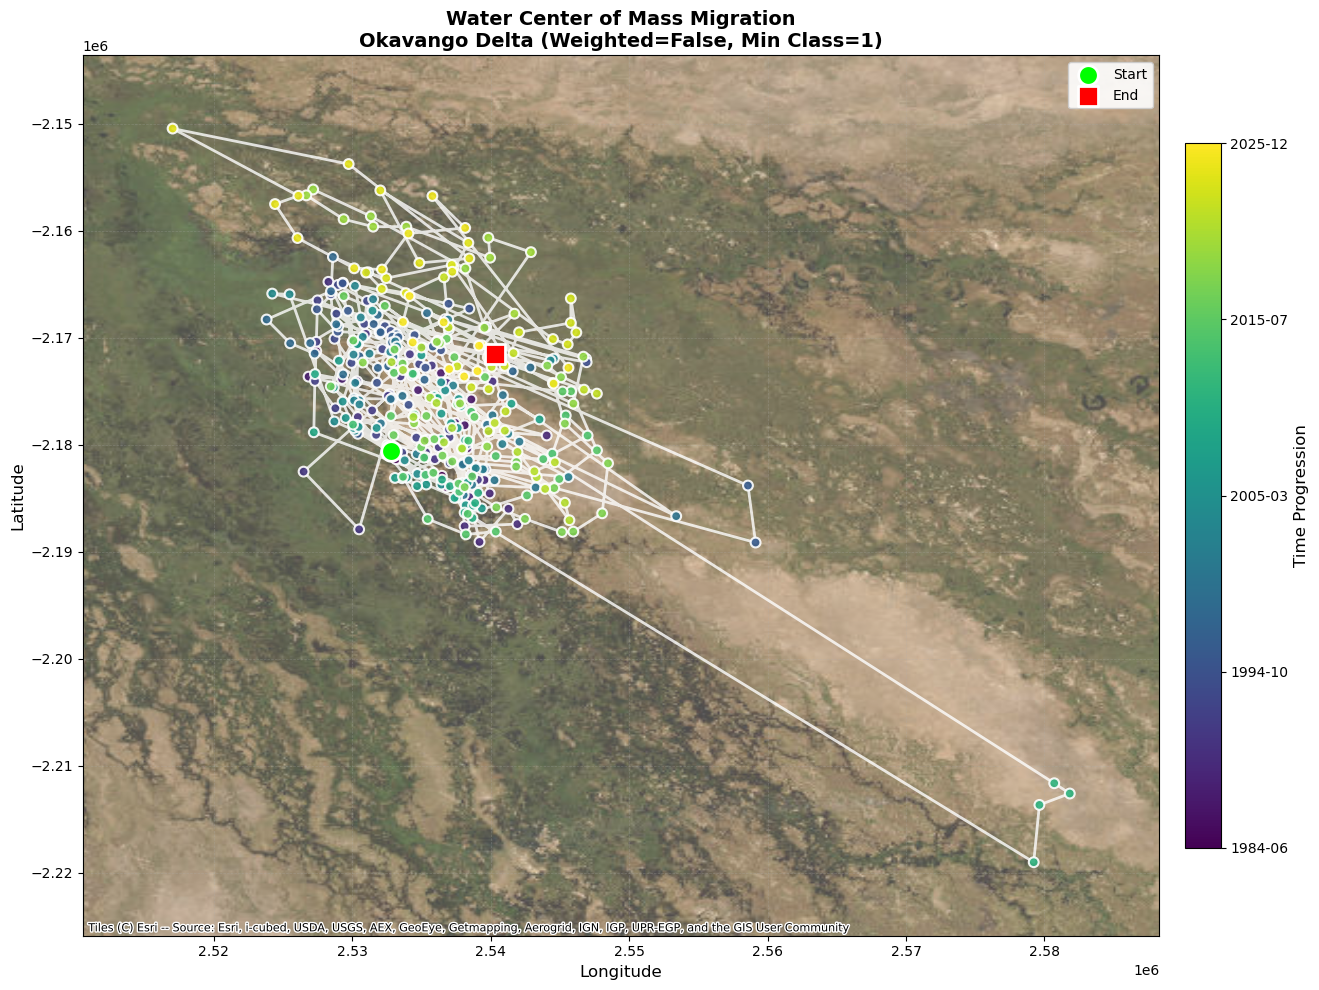

In [11]:
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import contextily as ctx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def calculate_water_centroid_timeseries(asset_folder, weighted=True, lowest_DSWE_class=1):
    """
    Calculate center of mass for all monthly DSWE products.
    
    Parameters:
    -----------
    asset_folder : str
        GEE folder path containing DSWE products
    weighted : bool
        If True, weight by DSWE confidence values; if False, binary (all water pixels equal)
    lowest_DSWE_class : int
        Minimum DSWE class to consider as water (1-4)
    
    Returns:
    --------
    pd.DataFrame
        Time series with columns: year, month, date, longitude, latitude, 
        total_water_area_km2, n_water_pixels, weighted, lowest_class
    """
    
    # Get list of all assets in folder
    asset_list = ee.data.listAssets({'parent': asset_folder})['assets']
    
    print(f"Found {len(asset_list)} assets in {asset_folder}")
    print(f"Configuration: weighted={weighted}, lowest_DSWE_class={lowest_DSWE_class}")
    print("-" * 60)
    
    results = []
    
    for asset in asset_list:
        asset_id = asset['name']
        
        # Extract year and month from asset name
        try:
            asset_name = asset_id.split('/')[-1]
            parts = asset_name.split('_')
            year = int(parts[1])
            month = int(parts[2])
            date_str = f"{year}-{month:02d}-01"
            
            print(f"Processing {year}-{month:02d}...", end=' ')
            
            # Load DSWE image
            img = ee.Image(asset_id).select('dswe')
            
            # Create water mask based on lowest_DSWE_class threshold
            water_mask = img.gte(lowest_DSWE_class)
            
            # Create weight image
            if weighted:
                # Use DSWE values as weights (1-4)
                weights = img.updateMask(water_mask)
            else:
                # Binary: all water pixels have weight of 1
                weights = water_mask.selfMask()
            
            # Get coordinate images
            coords = ee.Image.pixelLonLat()
            lon_img = coords.select('longitude')
            lat_img = coords.select('latitude')
            
            # Get pixel area for water area calculation
            pixel_area = ee.Image.pixelArea()
            
            # Calculate weighted sums
            weighted_lon = lon_img.multiply(weights)
            weighted_lat = lat_img.multiply(weights)
            
            # Reduce region to get sums
            reduction = ee.Image.cat([
                weighted_lon.rename('weighted_lon'),
                weighted_lat.rename('weighted_lat'),
                weights.rename('total_weight'),
                water_mask.multiply(pixel_area).rename('water_area'),
                water_mask.rename('pixel_count')
            ]).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=img.geometry(),
                scale=30,
                maxPixels=1e9
            )
            
            # Get results
            result = reduction.getInfo()
            
            # Calculate centroid
            total_weight = result['total_weight']
            if total_weight and total_weight > 0:
                centroid_lon = result['weighted_lon'] / total_weight
                centroid_lat = result['weighted_lat'] / total_weight
                water_area_km2 = result['water_area'] / 1e6
                n_pixels = result['pixel_count']
                
                results.append({
                    'year': year,
                    'month': month,
                    'date': date_str,
                    'longitude': centroid_lon,
                    'latitude': centroid_lat,
                    'total_water_area_km2': water_area_km2,
                    'n_water_pixels': int(n_pixels),
                    'weighted': weighted,
                    'lowest_class': lowest_DSWE_class
                })
                
                print(f"✓ Centroid: ({centroid_lon:.4f}, {centroid_lat:.4f}), Area: {water_area_km2:.1f} km²")
            else:
                print(f"✗ No water detected")
                
        except Exception as e:
            print(f"✗ Error: {e}")
            continue
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    
    print("-" * 60)
    print(f"Successfully processed {len(df)} months with water detections")
    
    return df


def export_centroid_results(df, output_csv='centroid_timeseries.csv', 
                            output_plot='centroid_path.png', 
                            basemap_bounds=None,
                            figsize=(14, 10)):
    """
    Export centroid time series as CSV and visualization.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame from calculate_water_centroid_timeseries()
    output_csv : str
        Path for CSV export
    output_plot : str
        Path for plot image export
    basemap_bounds : list, optional
        [min_lon, min_lat, max_lon, max_lat] for basemap extent
        If None, automatically determined from data
    figsize : tuple
        Figure size (width, height) in inches
    
    Returns:
    --------
    None (saves files to disk)
    """
    
    # Export CSV
    df.to_csv(output_csv, index=False)
    print(f"CSV exported to: {output_csv}")
    
    # Prepare data for plotting
    if len(df) == 0:
        print("No data to plot!")
        return
    
    # Determine bounds
    if basemap_bounds is None:
        lon_buffer = (df['longitude'].max() - df['longitude'].min()) * 0.1
        lat_buffer = (df['latitude'].max() - df['latitude'].min()) * 0.1
        min_lon = df['longitude'].min() - lon_buffer
        max_lon = df['longitude'].max() + lon_buffer
        min_lat = df['latitude'].min() - lat_buffer
        max_lat = df['latitude'].max() + lat_buffer
    else:
        min_lon, min_lat, max_lon, max_lat = basemap_bounds
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Convert to Web Mercator for basemap
    df_plot = df.copy()
    # Using a simple approximation for Web Mercator
    from pyproj import Transformer
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    df_plot['x'], df_plot['y'] = transformer.transform(df_plot['longitude'].values, 
                                                        df_plot['latitude'].values)
    
    # Set extent in Web Mercator
    xmin, ymin = transformer.transform(min_lon, min_lat)
    xmax, ymax = transformer.transform(max_lon, max_lat)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # Add basemap
    try:
        ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zoom=10, alpha=0.7)
        print("Basemap added successfully")
    except Exception as e:
        print(f"Warning: Could not add basemap: {e}")
        ax.set_facecolor('#E8E8E8')
    
    # Create color map based on time
    df_plot['time_numeric'] = (df_plot['date'] - df_plot['date'].min()).dt.days
    norm = Normalize(vmin=df_plot['time_numeric'].min(), vmax=df_plot['time_numeric'].max())
    cmap = plt.cm.viridis
    
    # Plot the path
    ax.plot(df_plot['x'], df_plot['y'], 
            linewidth=2, color='white', alpha=0.8, linestyle='-', zorder=2)
    
    # Plot points colored by time
    scatter = ax.scatter(df_plot['x'], df_plot['y'], 
                        c=df_plot['time_numeric'], 
                        cmap=cmap, norm=norm,
                        s=50, edgecolors='white', linewidth=1.5,
                        zorder=3, alpha=0.9)
    
    # Add start and end markers
    ax.scatter(df_plot.iloc[0]['x'], df_plot.iloc[0]['y'], 
              marker='o', s=200, color='lime', edgecolors='white', 
              linewidth=2, zorder=4, label='Start')
    ax.scatter(df_plot.iloc[-1]['x'], df_plot.iloc[-1]['y'], 
              marker='s', s=200, color='red', edgecolors='white', 
              linewidth=2, zorder=4, label='End')
    
    # Add colorbar
    cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, 
                       orientation='vertical', pad=0.02, shrink=0.8)
    cbar.set_label('Time Progression', fontsize=12)
    
    # Format colorbar labels as dates
    n_ticks = 5
    tick_positions = np.linspace(df_plot['time_numeric'].min(), 
                                 df_plot['time_numeric'].max(), n_ticks)
    tick_dates = [df_plot['date'].min() + pd.Timedelta(days=int(pos)) 
                  for pos in tick_positions]
    cbar.set_ticks(tick_positions)
    cbar.set_ticklabels([d.strftime('%Y-%m') for d in tick_dates])
    
    # Labels and title
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)
    
    config_str = f"Weighted={df.iloc[0]['weighted']}, Min Class={df.iloc[0]['lowest_class']}"
    title = f'Water Center of Mass Migration\nOkavango Delta ({config_str})'
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    ax.legend(loc='upper right', fontsize=10, framealpha=0.9)
    
    # Add grid
    ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    plt.tight_layout()
    plt.savefig(output_plot, dpi=300, bbox_inches='tight')
    print(f"Plot exported to: {output_plot}")
    plt.show()


# Example usage
if __name__ == "__main__":
    # Initialize Earth Engine
    ee.Initialize()
    
    # Define asset folder
    asset_folder = "projects/ee-okavango/assets/water_masks/monthly_DSWE_Landsat_30m_v4/DSWE_Products"
    
    # Example 1: Default configuration (weighted, all water classes)
    print("=" * 60)
    print("Running unweighted (binary) center of mass, all water classes")
    print("=" * 60)
    df_default = calculate_water_centroid_timeseries(
        asset_folder=asset_folder,
        weighted=False,
        lowest_DSWE_class=1
    )
    
    export_centroid_results(
        df=df_default,
        output_csv=r'D:\Okavango\Data\Inundation\Center_of_Mass\centroid_binary_all.csv',
        output_plot=r'D:\Okavango\Data\Inundation\Center_of_Mass\centroid_binary_all.png'
    )

## Monthly center of mass from 2014-2025:

Loaded 143 observations for 2014-2025
Fixed extent: Lon 22.397 to 23.095, Lat -19.629 to -18.726
Plotting 2014: 12 months
Plotting 2015: 12 months
Plotting 2016: 12 months
Plotting 2017: 12 months
Plotting 2018: 12 months
Plotting 2019: 12 months
Plotting 2020: 11 months
Plotting 2021: 12 months
Plotting 2022: 12 months
Plotting 2023: 12 months
Plotting 2024: 12 months
Plotting 2025: 12 months


C:\Users\huckr\AppData\Local\Temp\ipykernel_19280\1802080300.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.93, 1.0])


Saved: D:\Okavango\Data\Inundation\Center_of_Mass\centroid_migration_2014_2025.svg
Saved: D:\Okavango\Data\Inundation\Center_of_Mass\centroid_migration_2014_2025.png
Saved: D:\Okavango\Data\Inundation\Center_of_Mass\centroid_migration_2014_2025.jpeg


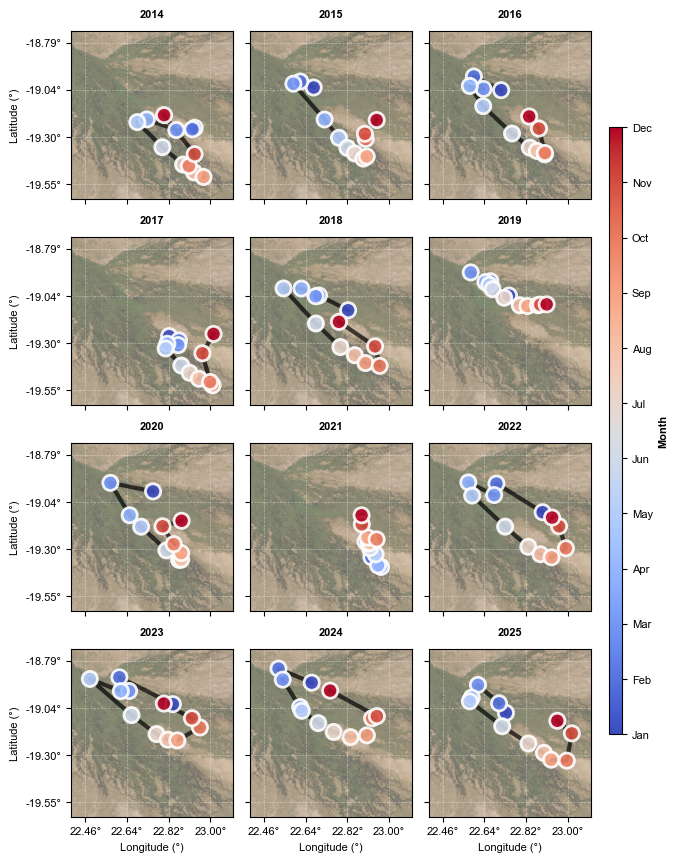


Years plotted: 12
Total observations: 143
Average months per year: 11.9


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import Transformer
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as mticker
import os

def plot_centroid_multipanel(csv_path, start_year, end_year, output_dir, cols=3):
    """
    Create multi-panel plot showing center of mass migration for each year.
    Points colored by month, all same size.
    
    Parameters:
    -----------
    csv_path : str
        Path to the centroid CSV file
    start_year : int
        First year to plot
    end_year : int
        Last year to plot
    output_dir : str
        Directory path to save output files
    cols : int
        Number of columns in the panel layout
    """
    
    # Set font to Arial 8pt for all text
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 8
    
    # Read CSV
    df = pd.read_csv(csv_path)
    df['date'] = pd.to_datetime(df['date'])
    
    # Filter to requested year range
    df = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    
    if len(df) == 0:
        print(f"No data found for years {start_year}-{end_year}")
        return
    
    print(f"Loaded {len(df)} observations for {start_year}-{end_year}")
    
    # Convert to Web Mercator for basemap plotting
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    df['x'], df['y'] = transformer.transform(df['longitude'].values, df['latitude'].values)
    
    # Create inverse transformer for axis labels
    inverse_transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
    
    # Calculate FIXED extent for all panels (same extent for all)
    lon_buffer = (df['longitude'].max() - df['longitude'].min()) * 0.15
    lat_buffer = (df['latitude'].max() - df['latitude'].min()) * 0.15
    min_lon = df['longitude'].min() - lon_buffer
    max_lon = df['longitude'].max() + lon_buffer
    min_lat = df['latitude'].min() - lat_buffer
    max_lat = df['latitude'].max() + lat_buffer
    
    xmin, ymin = transformer.transform(min_lon, min_lat)
    xmax, ymax = transformer.transform(max_lon, max_lat)
    
    print(f"Fixed extent: Lon {min_lon:.3f} to {max_lon:.3f}, Lat {min_lat:.3f} to {max_lat:.3f}")
    
    # Determine grid layout
    years = sorted(df['year'].unique())
    n_years = len(years)
    rows = int(np.ceil(n_years / cols))
    
    # Set figure width to 6.5 inches, calculate height proportionally
    fig_width = 6.5
    fig_height = fig_width * (rows / cols)
    figsize = (fig_width, fig_height)
    
    # Create colormap for months
    month_norm = Normalize(vmin=1, vmax=12)
    month_cmap = plt.cm.coolwarm  # Cool for Jan, warm for Dec
    
    # Create figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Flatten axes array for easier iteration
    if n_years == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Formatter functions for lat/long
    def format_lon(x, pos):
        lon, _ = inverse_transformer.transform(x, ymin)
        return f'{lon:.2f}°'
    
    def format_lat(y, pos):
        _, lat = inverse_transformer.transform(xmin, y)
        return f'{lat:.2f}°'
    
    # Plot each year in its own panel
    for idx, year in enumerate(years):
        ax = axes[idx]
        year_data = df[df['year'] == year].sort_values('month')
        
        print(f"Plotting {year}: {len(year_data)} months")
        
        # Set FIXED extent for all panels
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        
        # Add basemap without attribution
        try:
            ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, 
                          zoom=11, alpha=0.6, attribution="")
        except Exception as e:
            ax.set_facecolor('#E8E8E8')
        
        # Plot connecting line (bolder and darker)
        if len(year_data) > 1:
            ax.plot(year_data['x'], year_data['y'],
                   linewidth=3, color='black', alpha=0.7, zorder=2)
        
        # Plot points colored by month, all same size
        scatter = ax.scatter(year_data['x'], year_data['y'],
                           c=year_data['month'], cmap=month_cmap, norm=month_norm,
                           s=120,  # Same size for all points
                           edgecolors='white', linewidth=2, 
                           zorder=3, alpha=0.9)
        
        # Format axes
        ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_lon))
        ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_lat))
        
        # Reduce number of ticks
        ax.xaxis.set_major_locator(mticker.MaxNLocator(4))
        ax.yaxis.set_major_locator(mticker.MaxNLocator(4))
        
        # Set tick label font size
        ax.tick_params(axis='both', labelsize=8)
        
        # Determine if this panel is on the left column or bottom row
        is_left_column = (idx % cols == 0)
        is_bottom_row = (idx >= (rows - 1) * cols)
        
        # Show/hide tick labels based on position
        if not is_left_column:
            ax.set_yticklabels([])  # Hide y-axis tick labels
        
        if not is_bottom_row:
            ax.set_xticklabels([])  # Hide x-axis tick labels
        
        # Add grid
        ax.grid(True, alpha=0.4, linestyle='--', linewidth=0.5, color='white')
        
        # Title with year (8pt Arial)
        ax.set_title(f'{year}', fontsize=8, fontweight='bold', pad=10, fontname='Arial')
        
        # Add axis labels only to left and bottom edges
        if is_left_column:
            ax.set_ylabel('Latitude (°)', fontsize=8, fontname='Arial')
        
        if is_bottom_row:
            ax.set_xlabel('Longitude (°)', fontsize=8, fontname='Arial')
    
    # Hide unused subplots
    for idx in range(n_years, len(axes)):
        axes[idx].axis('off')
    
    # Add shared colorbar
    fig.subplots_adjust(right=0.92)
    cbar_ax = fig.add_axes([0.94, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(ScalarMappable(norm=month_norm, cmap=month_cmap), 
                       cax=cbar_ax, orientation='vertical')
    cbar.set_label('Month', fontsize=8, fontname='Arial', fontweight='bold')
    cbar.set_ticks(range(1, 13))
    cbar.set_ticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                         'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
                        fontsize=8, fontname='Arial')
    cbar.ax.tick_params(labelsize=8)
    
    plt.tight_layout(rect=[0, 0, 0.93, 1.0])
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate output filename base
    filename_base = f'centroid_migration_{start_year}_{end_year}'
    
    # Save as SVG
    svg_path = os.path.join(output_dir, f'{filename_base}.svg')
    plt.savefig(svg_path, format='svg', dpi=300, bbox_inches='tight')
    print(f"Saved: {svg_path}")
    
    # Save as PNG
    png_path = os.path.join(output_dir, f'{filename_base}.png')
    plt.savefig(png_path, format='png', dpi=300, bbox_inches='tight')
    print(f"Saved: {png_path}")
    
    # Save as JPEG
    jpeg_path = os.path.join(output_dir, f'{filename_base}.jpeg')
    plt.savefig(jpeg_path, format='jpeg', dpi=300, bbox_inches='tight')
    print(f"Saved: {jpeg_path}")
    
    plt.show()
    
    # Print statistics
    print(f"\nYears plotted: {n_years}")
    print(f"Total observations: {len(df)}")
    print(f"Average months per year: {len(df)/n_years:.1f}")
    
    # Reset font settings to default
    plt.rcParams.update(plt.rcParamsDefault)

# Example usage
plot_centroid_multipanel(r"D:\Okavango\Data\Inundation\Center_of_Mass\centroid_binary_highconf.csv", 
                        start_year=2014, 
                        end_year=2025,
                        output_dir=r'D:\Okavango\Data\Inundation\Center_of_Mass',
                        cols=3)

## Annual mean center of mass:

Loaded 368 monthly observations for 1984-2025

Calculated annual means for 38 years
Average months per year: 9.7
Extent: Lon 22.531 to 22.982, Lat -19.459 to -18.864
Basemap added successfully
Saved: D:\Okavango\Data\Inundation\Center_of_Mass\annual_centroid_1984_2025.svg
Saved: D:\Okavango\Data\Inundation\Center_of_Mass\annual_centroid_1984_2025.png
Saved: D:\Okavango\Data\Inundation\Center_of_Mass\annual_centroid_1984_2025.jpeg


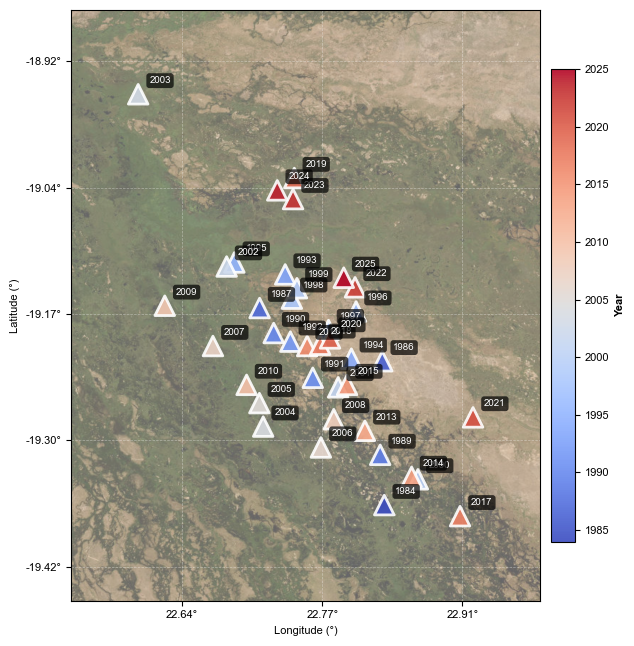


Annual centroid statistics:
Longitude range: 22.5953° to 22.9173°
Latitude range: -19.3738° to -18.9489°
Mean water area: 1111.4 km²


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import Transformer
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.ticker as mticker
import os

def plot_annual_centroid(csv_path, start_year, end_year, output_dir):
    """
    Plot mean annual center of mass for each year as triangles.
    Colors range from cool (start year) to warm (end year).
    
    Parameters:
    -----------
    csv_path : str
        Path to the centroid CSV file with monthly data
    start_year : int
        First year to plot
    end_year : int
        Last year to plot
    output_dir : str
        Directory path to save output files
    """
    
    # Set font to Arial 8pt for all text
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 8
    
    # Read CSV
    df = pd.read_csv(csv_path)
    df['date'] = pd.to_datetime(df['date'])
    
    # Filter to requested year range
    df = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    
    if len(df) == 0:
        print(f"No data found for years {start_year}-{end_year}")
        return
    
    print(f"Loaded {len(df)} monthly observations for {start_year}-{end_year}")
    
    # Calculate mean annual centroid for each year
    annual_means = df.groupby('year').agg({
        'longitude': 'mean',
        'latitude': 'mean',
        'total_water_area_km2': 'mean',
        'n_water_pixels': 'sum'
    }).reset_index()
    
    annual_means['n_months'] = df.groupby('year').size().values
    
    print(f"\nCalculated annual means for {len(annual_means)} years")
    print(f"Average months per year: {annual_means['n_months'].mean():.1f}")
    
    # Convert to Web Mercator for basemap plotting
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    annual_means['x'], annual_means['y'] = transformer.transform(
        annual_means['longitude'].values, 
        annual_means['latitude'].values
    )
    
    # Create inverse transformer for axis labels
    inverse_transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
    
    # Calculate extent with buffer
    lon_buffer = (annual_means['longitude'].max() - annual_means['longitude'].min()) * 0.2
    lat_buffer = (annual_means['latitude'].max() - annual_means['latitude'].min()) * 0.2
    min_lon = annual_means['longitude'].min() - lon_buffer
    max_lon = annual_means['longitude'].max() + lon_buffer
    min_lat = annual_means['latitude'].min() - lat_buffer
    max_lat = annual_means['latitude'].max() + lat_buffer
    
    xmin, ymin = transformer.transform(min_lon, min_lat)
    xmax, ymax = transformer.transform(max_lon, max_lat)
    
    print(f"Extent: Lon {min_lon:.3f} to {max_lon:.3f}, Lat {min_lat:.3f} to {max_lat:.3f}")
    
    # Set figure width to 6.5 inches, make it square
    fig_width = 6.5
    fig_height = 6.5
    figsize = (fig_width, fig_height)
    
    # Create colormap for years
    year_norm = Normalize(vmin=start_year, vmax=end_year)
    year_cmap = plt.cm.coolwarm  # Cool for start year, warm for end year
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set extent
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # Add basemap without attribution
    try:
        ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, 
                      zoom=11, alpha=0.6, attribution="")
        print("Basemap added successfully")
    except Exception as e:
        print(f"Warning: Could not add basemap: {e}")
        ax.set_facecolor('#E8E8E8')
    
    # Plot triangles colored by year
    scatter = ax.scatter(annual_means['x'], annual_means['y'],
                       c=annual_means['year'], cmap=year_cmap, norm=year_norm,
                       s=200,  # Triangle size
                       marker='^',  # Triangle marker
                       edgecolors='white', linewidth=2, 
                       zorder=3, alpha=0.9)
    
    # Add year labels next to each triangle
    for idx, row in annual_means.iterrows():
        ax.annotate(str(int(row['year'])), 
                   xy=(row['x'], row['y']),
                   xytext=(8, 8), textcoords='offset points',
                   fontsize=7, fontname='Arial',
                   color='white',
                   bbox=dict(boxstyle='round,pad=0.3', 
                           facecolor='black', 
                           edgecolor='none',
                           alpha=0.7),
                   zorder=4)
    
    # Format axes to show lat/long
    def format_lon(x, pos):
        lon, _ = inverse_transformer.transform(x, ymin)
        return f'{lon:.2f}°'
    
    def format_lat(y, pos):
        _, lat = inverse_transformer.transform(xmin, y)
        return f'{lat:.2f}°'
    
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_lon))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(format_lat))
    
    # Set tick parameters
    ax.xaxis.set_major_locator(mticker.MaxNLocator(5))
    ax.yaxis.set_major_locator(mticker.MaxNLocator(5))
    ax.tick_params(axis='both', labelsize=8)
    
    # Add grid
    ax.grid(True, alpha=0.4, linestyle='--', linewidth=0.5, color='white')
    
    # Add axis labels
    ax.set_xlabel('Longitude (°)', fontsize=8, fontname='Arial')
    ax.set_ylabel('Latitude (°)', fontsize=8, fontname='Arial')
    
    # Add colorbar for years
    cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', 
                       pad=0.02, shrink=0.8)
    cbar.set_label('Year', fontsize=8, fontname='Arial', fontweight='bold')
    cbar.ax.tick_params(labelsize=8)
    
    plt.tight_layout()
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Generate output filename base
    filename_base = f'annual_centroid_{start_year}_{end_year}'
    
    # Save as SVG
    svg_path = os.path.join(output_dir, f'{filename_base}.svg')
    plt.savefig(svg_path, format='svg', dpi=300, bbox_inches='tight')
    print(f"Saved: {svg_path}")
    
    # Save as PNG
    png_path = os.path.join(output_dir, f'{filename_base}.png')
    plt.savefig(png_path, format='png', dpi=300, bbox_inches='tight')
    print(f"Saved: {png_path}")
    
    # Save as JPEG
    jpeg_path = os.path.join(output_dir, f'{filename_base}.jpeg')
    plt.savefig(jpeg_path, format='jpeg', dpi=300, bbox_inches='tight')
    print(f"Saved: {jpeg_path}")
    
    plt.show()
    
    # Print statistics
    print(f"\nAnnual centroid statistics:")
    print(f"Longitude range: {annual_means['longitude'].min():.4f}° to {annual_means['longitude'].max():.4f}°")
    print(f"Latitude range: {annual_means['latitude'].min():.4f}° to {annual_means['latitude'].max():.4f}°")
    print(f"Mean water area: {annual_means['total_water_area_km2'].mean():.1f} km²")
    
    # Reset font settings to default
    plt.rcParams.update(plt.rcParamsDefault)
    
    return annual_means

# Example usage
annual_df = plot_annual_centroid(r"D:\Okavango\Data\Inundation\Center_of_Mass\centroid_binary_highconf.csv", 
                                 start_year=1984, 
                                 end_year=2025,
                                 output_dir=r'D:\Okavango\Data\Inundation\Center_of_Mass')

TEMPORAL TREND ANALYSIS OF WATER CENTROID MIGRATION
Period: 1984-2025 (38 years)

Average latitude: -19.2027°
Conversion factors:
  1° latitude = 111320 m
  1° longitude = 105126 m (at -19.2°)

LONGITUDE (EAST-WEST) ANALYSIS

1. Standard OLS:
   Slope: 0.000649°/year (68.2 m/year eastward)
   p-value: 0.4943
   R²: 0.0131

2. OLS with Newey-West HAC Standard Errors (robust to autocorrelation):
   Slope: 0.000649°/year (68.2 m/year eastward)
   p-value: 0.4124
   95% CI: [-0.000903, 0.002201]°/year
   Total displacement (1984-2025): 2797 m

3. GLS with AR(1) structure:
   Estimated AR(1) coefficient: 0.1503
   Slope: 0.001097°/year (115.3 m/year eastward)
   p-value: 0.3419

4. Durbin-Watson statistic: 1.6652
   (Values near 2 suggest no autocorrelation; <2 suggests positive autocorrelation)

LATITUDE (NORTH-SOUTH) ANALYSIS

1. Standard OLS:
   Slope: 0.001312°/year (146.1 m/year northward)
   p-value: 0.3084
   R²: 0.0288

2. OLS with Newey-West HAC Standard Errors (robust to autocorre

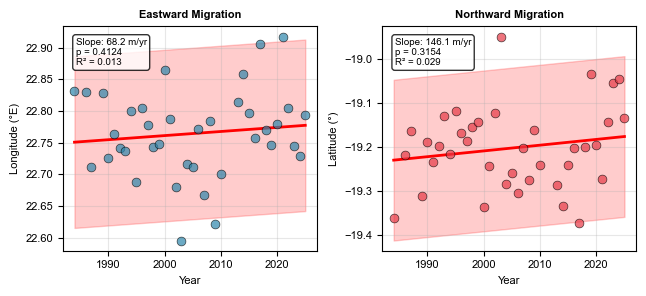

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.sandwich_covariance import cov_hac
import os

def analyze_centroid_trend(csv_path, start_year, end_year, output_dir):
    """
    Conduct temporal trend analysis of centroid migration with autocorrelation correction.
    
    Parameters:
    -----------
    csv_path : str
        Path to the centroid CSV file with monthly data
    start_year : int
        First year to analyze
    end_year : int
        Last year to analyze
    output_dir : str
        Directory path to save output files
    """
    
    # Set font to Arial 8pt
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 8
    
    # Read CSV and calculate annual means
    df = pd.read_csv(csv_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    
    annual_means = df.groupby('year').agg({
        'longitude': 'mean',
        'latitude': 'mean',
        'total_water_area_km2': 'mean'
    }).reset_index()
    
    annual_means['n_months'] = df.groupby('year').size().values
    
    print("=" * 70)
    print("TEMPORAL TREND ANALYSIS OF WATER CENTROID MIGRATION")
    print(f"Period: {start_year}-{end_year} ({len(annual_means)} years)")
    print("=" * 70)
    
    # Calculate average latitude for longitude-to-meters conversion
    avg_lat = annual_means['latitude'].mean()
    deg_lat_to_m = 111320  # meters per degree latitude (constant)
    deg_lon_to_m = 111320 * np.cos(np.radians(avg_lat))  # meters per degree longitude (latitude-dependent)
    
    print(f"\nAverage latitude: {avg_lat:.4f}°")
    print(f"Conversion factors:")
    print(f"  1° latitude = {deg_lat_to_m:.0f} m")
    print(f"  1° longitude = {deg_lon_to_m:.0f} m (at {avg_lat:.1f}°)")
    
    # Prepare data for regression
    X = annual_means['year'].values
    X_with_const = sm.add_constant(X)
    
    # ===================================================================
    # LONGITUDE ANALYSIS
    # ===================================================================
    print("\n" + "=" * 70)
    print("LONGITUDE (EAST-WEST) ANALYSIS")
    print("=" * 70)
    
    y_lon = annual_means['longitude'].values
    
    # 1. Standard OLS regression
    ols_lon = OLS(y_lon, X_with_const).fit()
    
    # 2. OLS with Newey-West HAC standard errors (corrects for autocorrelation)
    nw_cov_lon = cov_hac(ols_lon, nlags=3)  # Use 3 lags for HAC
    ols_lon_nw = OLS(y_lon, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
    
    # 3. GLS with AR(1) structure
    # First, estimate AR(1) parameter from OLS residuals
    residuals_lon = ols_lon.resid
    ar1_coef_lon = np.corrcoef(residuals_lon[:-1], residuals_lon[1:])[0, 1]
    
    # Fit GLS with AR(1)
    from statsmodels.regression.linear_model import GLSAR
    gls_lon = GLSAR(y_lon, X_with_const, rho=1).iterative_fit(maxiter=10)
    
    # Extract results
    slope_lon_ols = ols_lon.params[1]
    slope_lon_nw = ols_lon_nw.params[1]
    slope_lon_gls = gls_lon.params[1]
    
    pval_lon_ols = ols_lon.pvalues[1]
    pval_lon_nw = ols_lon_nw.pvalues[1]
    pval_lon_gls = gls_lon.pvalues[1]
    
    # Convert slopes to meters per year
    slope_lon_m_ols = slope_lon_ols * deg_lon_to_m
    slope_lon_m_nw = slope_lon_nw * deg_lon_to_m
    slope_lon_m_gls = slope_lon_gls * deg_lon_to_m
    
    # Calculate total displacement over period
    n_years = end_year - start_year
    total_lon_m = slope_lon_nw * n_years * deg_lon_to_m
    
    print("\n1. Standard OLS:")
    print(f"   Slope: {slope_lon_ols:.6f}°/year ({slope_lon_m_ols:.1f} m/year eastward)")
    print(f"   p-value: {pval_lon_ols:.4f}")
    print(f"   R²: {ols_lon.rsquared:.4f}")
    
    print("\n2. OLS with Newey-West HAC Standard Errors (robust to autocorrelation):")
    print(f"   Slope: {slope_lon_nw:.6f}°/year ({slope_lon_m_nw:.1f} m/year eastward)")
    print(f"   p-value: {pval_lon_nw:.4f}")
    print(f"   95% CI: [{ols_lon_nw.conf_int()[1, 0]:.6f}, {ols_lon_nw.conf_int()[1, 1]:.6f}]°/year")
    print(f"   Total displacement ({start_year}-{end_year}): {total_lon_m:.0f} m")
    
    print("\n3. GLS with AR(1) structure:")
    print(f"   Estimated AR(1) coefficient: {ar1_coef_lon:.4f}")
    print(f"   Slope: {slope_lon_gls:.6f}°/year ({slope_lon_m_gls:.1f} m/year eastward)")
    print(f"   p-value: {pval_lon_gls:.4f}")
    
    # Test for autocorrelation
    from statsmodels.stats.stattools import durbin_watson
    dw_lon = durbin_watson(ols_lon.resid)
    print(f"\n4. Durbin-Watson statistic: {dw_lon:.4f}")
    print(f"   (Values near 2 suggest no autocorrelation; <2 suggests positive autocorrelation)")
    
    # ===================================================================
    # LATITUDE ANALYSIS
    # ===================================================================
    print("\n" + "=" * 70)
    print("LATITUDE (NORTH-SOUTH) ANALYSIS")
    print("=" * 70)
    
    y_lat = annual_means['latitude'].values
    
    # 1. Standard OLS regression
    ols_lat = OLS(y_lat, X_with_const).fit()
    
    # 2. OLS with Newey-West HAC standard errors
    ols_lat_nw = OLS(y_lat, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
    
    # 3. GLS with AR(1) structure
    residuals_lat = ols_lat.resid
    ar1_coef_lat = np.corrcoef(residuals_lat[:-1], residuals_lat[1:])[0, 1]
    gls_lat = GLSAR(y_lat, X_with_const, rho=1).iterative_fit(maxiter=10)
    
    # Extract results
    slope_lat_ols = ols_lat.params[1]
    slope_lat_nw = ols_lat_nw.params[1]
    slope_lat_gls = gls_lat.params[1]
    
    pval_lat_ols = ols_lat.pvalues[1]
    pval_lat_nw = ols_lat_nw.pvalues[1]
    pval_lat_gls = gls_lat.pvalues[1]
    
    # Convert slopes to meters per year (positive = northward)
    slope_lat_m_ols = slope_lat_ols * deg_lat_to_m
    slope_lat_m_nw = slope_lat_nw * deg_lat_to_m
    slope_lat_m_gls = slope_lat_gls * deg_lat_to_m
    
    # Calculate total displacement
    total_lat_m = slope_lat_nw * n_years * deg_lat_to_m
    
    print("\n1. Standard OLS:")
    print(f"   Slope: {slope_lat_ols:.6f}°/year ({slope_lat_m_ols:.1f} m/year northward)")
    print(f"   p-value: {pval_lat_ols:.4f}")
    print(f"   R²: {ols_lat.rsquared:.4f}")
    
    print("\n2. OLS with Newey-West HAC Standard Errors (robust to autocorrelation):")
    print(f"   Slope: {slope_lat_nw:.6f}°/year ({slope_lat_m_nw:.1f} m/year northward)")
    print(f"   p-value: {pval_lat_nw:.4f}")
    print(f"   95% CI: [{ols_lat_nw.conf_int()[1, 0]:.6f}, {ols_lat_nw.conf_int()[1, 1]:.6f}]°/year")
    print(f"   Total displacement ({start_year}-{end_year}): {total_lat_m:.0f} m")
    
    print("\n3. GLS with AR(1) structure:")
    print(f"   Estimated AR(1) coefficient: {ar1_coef_lat:.4f}")
    print(f"   Slope: {slope_lat_gls:.6f}°/year ({slope_lat_m_gls:.1f} m/year northward)")
    print(f"   p-value: {pval_lat_gls:.4f}")
    
    dw_lat = durbin_watson(ols_lat.resid)
    print(f"\n4. Durbin-Watson statistic: {dw_lat:.4f}")
    
    # ===================================================================
    # COMBINED INTERPRETATION
    # ===================================================================
    print("\n" + "=" * 70)
    print("COMBINED DIRECTIONAL ANALYSIS")
    print("=" * 70)
    
    # Calculate resultant displacement vector
    total_displacement_m = np.sqrt(total_lon_m**2 + total_lat_m**2)
    bearing = np.degrees(np.arctan2(total_lon_m, total_lat_m))  # Bearing from north
    if bearing < 0:
        bearing += 360
    
    print(f"\nTotal centroid displacement ({start_year}-{end_year}):")
    print(f"   Eastward: {total_lon_m:.0f} m")
    print(f"   Northward: {total_lat_m:.0f} m")
    print(f"   Resultant: {total_displacement_m:.0f} m")
    print(f"   Bearing: {bearing:.1f}° (clockwise from north)")
    
    # Interpret bearing
    if 0 <= bearing < 22.5 or 337.5 <= bearing < 360:
        direction = "North"
    elif 22.5 <= bearing < 67.5:
        direction = "Northeast"
    elif 67.5 <= bearing < 112.5:
        direction = "East"
    elif 112.5 <= bearing < 157.5:
        direction = "Southeast"
    elif 157.5 <= bearing < 202.5:
        direction = "South"
    elif 202.5 <= bearing < 247.5:
        direction = "Southwest"
    elif 247.5 <= bearing < 292.5:
        direction = "West"
    else:
        direction = "Northwest"
    
    print(f"   Cardinal direction: {direction}")
    
    # Calculate rate of displacement
    rate_m_per_year = total_displacement_m / n_years
    print(f"   Average rate: {rate_m_per_year:.1f} m/year")
    
    # ===================================================================
    # CREATE VISUALIZATION
    # ===================================================================
    fig, axes = plt.subplots(1, 2, figsize=(6.5, 3))
    
    # Longitude plot
    ax1 = axes[0]
    ax1.scatter(X, y_lon, s=40, color='#2E86AB', alpha=0.7, edgecolors='black', linewidth=0.5, zorder=3)
    
    # Plot regression lines
    pred_lon = ols_lon_nw.predict(X_with_const)
    ax1.plot(X, pred_lon, color='red', linewidth=2, label='Linear trend', zorder=2)
    
    # Add confidence interval
    pred_std = np.sqrt(ols_lon_nw.mse_resid)
    ax1.fill_between(X, pred_lon - 1.96*pred_std, pred_lon + 1.96*pred_std,
                     color='red', alpha=0.2, zorder=1)
    
    ax1.set_xlabel('Year', fontsize=8, fontname='Arial')
    ax1.set_ylabel('Longitude (°E)', fontsize=8, fontname='Arial')
    ax1.set_title('Eastward Migration', fontsize=8, fontweight='bold', fontname='Arial')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(labelsize=8)
    
    # Add text box with statistics
    text_lon = f'Slope: {slope_lon_m_nw:.1f} m/yr\np = {pval_lon_nw:.4f}\nR² = {ols_lon_nw.rsquared:.3f}'
    ax1.text(0.05, 0.95, text_lon, transform=ax1.transAxes,
            fontsize=7, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Latitude plot
    ax2 = axes[1]
    ax2.scatter(X, y_lat, s=40, color='#E63946', alpha=0.7, edgecolors='black', linewidth=0.5, zorder=3)
    
    # Plot regression line
    pred_lat = ols_lat_nw.predict(X_with_const)
    ax2.plot(X, pred_lat, color='red', linewidth=2, label='Linear trend', zorder=2)
    
    # Add confidence interval
    pred_std_lat = np.sqrt(ols_lat_nw.mse_resid)
    ax2.fill_between(X, pred_lat - 1.96*pred_std_lat, pred_lat + 1.96*pred_std_lat,
                     color='red', alpha=0.2, zorder=1)
    
    ax2.set_xlabel('Year', fontsize=8, fontname='Arial')
    ax2.set_ylabel('Latitude (°)', fontsize=8, fontname='Arial')
    ax2.set_title('Northward Migration', fontsize=8, fontweight='bold', fontname='Arial')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(labelsize=8)
    
    # Add text box with statistics
    text_lat = f'Slope: {slope_lat_m_nw:.1f} m/yr\np = {pval_lat_nw:.4f}\nR² = {ols_lat_nw.rsquared:.3f}'
    ax2.text(0.05, 0.95, text_lat, transform=ax2.transAxes,
            fontsize=7, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    # Save outputs
    os.makedirs(output_dir, exist_ok=True)
    filename_base = f'centroid_trend_analysis_{start_year}_{end_year}'
    
    svg_path = os.path.join(output_dir, f'{filename_base}.svg')
    plt.savefig(svg_path, format='svg', dpi=300, bbox_inches='tight')
    print(f"\nSaved: {svg_path}")
    
    png_path = os.path.join(output_dir, f'{filename_base}.png')
    plt.savefig(png_path, format='png', dpi=300, bbox_inches='tight')
    print(f"Saved: {png_path}")
    
    jpeg_path = os.path.join(output_dir, f'{filename_base}.jpeg')
    plt.savefig(jpeg_path, format='jpeg', dpi=300, bbox_inches='tight')
    print(f"Saved: {jpeg_path}")
    
    plt.show()
    
    # Reset font settings
    plt.rcParams.update(plt.rcParamsDefault)
    
    # Return results as dictionary
    results = {
        'annual_data': annual_means,
        'longitude': {
            'slope_deg_per_year': slope_lon_nw,
            'slope_m_per_year': slope_lon_m_nw,
            'p_value': pval_lon_nw,
            'r_squared': ols_lon_nw.rsquared,
            'total_displacement_m': total_lon_m
        },
        'latitude': {
            'slope_deg_per_year': slope_lat_nw,
            'slope_m_per_year': slope_lat_m_nw,
            'p_value': pval_lat_nw,
            'r_squared': ols_lat_nw.rsquared,
            'total_displacement_m': total_lat_m
        },
        'combined': {
            'total_displacement_m': total_displacement_m,
            'bearing_degrees': bearing,
            'direction': direction,
            'rate_m_per_year': rate_m_per_year
        }
    }
    
    return results

# Example usage
results = analyze_centroid_trend(r"D:\Okavango\Data\Inundation\Center_of_Mass\centroid_binary_highconf.csv",
                                start_year=1984,
                                end_year=2025,
                                output_dir=r'D:\Okavango\Data\Inundation\Center_of_Mass')

## Streamwise trend analysis

STREAMWISE TEMPORAL TREND ANALYSIS
Period: 1984-2025 (38 years)

Reference point: (22.7659°E, -19.1767°S)
Conversion factors:
  1° latitude = 111320 m
  1° longitude = 105143 m

Streamwise coordinate system:
  Downstream (distal): 137°
  Upstream (proximal): 317°
  River left: 47°
  River right: 227°

CROSS-CHANNEL (LATERAL) ANALYSIS
Positive = River Left, Negative = River Right

1. Standard OLS:
   Slope: 160.6 m/year toward river left
   p-value: 0.0073
   R²: 0.1833

2. OLS with Newey-West HAC Standard Errors (robust to autocorrelation):
   Slope: 160.6 m/year toward river left
   p-value: 0.0323
   95% CI: [13.5, 307.7] m/year
   Total displacement (1984-2025): 6586 m river left

3. GLS with AR(1) structure:
   Estimated AR(1) coefficient: 0.5685
   Slope: 150.7 m/year toward river left
   p-value: 0.2009

4. Durbin-Watson statistic: 0.8536
   (Values near 2 suggest no autocorrelation; <2 suggests positive autocorrelation)

ALONG-CHANNEL (LONGITUDINAL) ANALYSIS
Positive = Downstrea

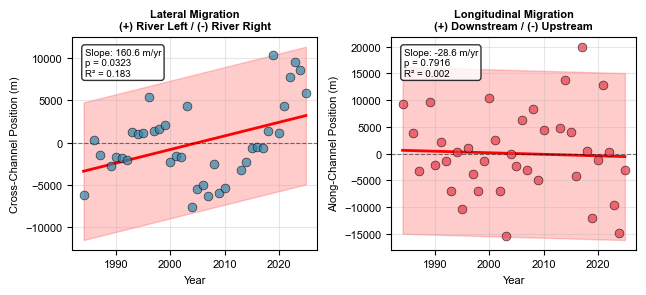

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.sandwich_covariance import cov_hac
import os

def analyze_centroid_trend_streamwise(csv_path, start_year, end_year, output_dir, 
                                      downstream_bearing=137.0):
    """
    Conduct temporal trend analysis of centroid migration in streamwise coordinates.
    Transforms geographic coordinates to channel-oriented reference frame.
    
    Parameters:
    -----------
    csv_path : str
        Path to the centroid CSV file with monthly data
    start_year : int
        First year to analyze
    end_year : int
        Last year to analyze
    output_dir : str
        Directory path to save output files
    downstream_bearing : float
        Bearing (degrees clockwise from north) of downstream/distal direction (default: 137°)
    """
    
    # Set font to Arial 8pt
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 8
    
    # Read CSV and calculate annual means
    df = pd.read_csv(csv_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df[(df['year'] >= start_year) & (df['year'] <= end_year)]
    
    annual_means = df.groupby('year').agg({
        'longitude': 'mean',
        'latitude': 'mean',
        'total_water_area_km2': 'mean'
    }).reset_index()
    
    annual_means['n_months'] = df.groupby('year').size().values
    
    print("=" * 70)
    print("STREAMWISE TEMPORAL TREND ANALYSIS")
    print(f"Period: {start_year}-{end_year} ({len(annual_means)} years)")
    print("=" * 70)
    
    # Calculate average latitude for longitude-to-meters conversion
    avg_lat = annual_means['latitude'].mean()
    avg_lon = annual_means['longitude'].mean()
    deg_lat_to_m = 111320  # meters per degree latitude (constant)
    deg_lon_to_m = 111320 * np.cos(np.radians(avg_lat))  # meters per degree longitude
    
    print(f"\nReference point: ({avg_lon:.4f}°E, {avg_lat:.4f}°S)")
    print(f"Conversion factors:")
    print(f"  1° latitude = {deg_lat_to_m:.0f} m")
    print(f"  1° longitude = {deg_lon_to_m:.0f} m")
    
    # Define streamwise coordinate system
    downstream_azimuth = downstream_bearing  # degrees clockwise from north
    upstream_azimuth = (downstream_azimuth + 180) % 360
    river_left_azimuth = (downstream_azimuth - 90) % 360
    river_right_azimuth = (downstream_azimuth + 90) % 360
    
    print(f"\nStreamwise coordinate system:")
    print(f"  Downstream (distal): {downstream_azimuth:.0f}°")
    print(f"  Upstream (proximal): {upstream_azimuth:.0f}°")
    print(f"  River left: {river_left_azimuth:.0f}°")
    print(f"  River right: {river_right_azimuth:.0f}°")
    
    # Convert geographic coordinates to Cartesian (meters) relative to mean position
    delta_lon = annual_means['longitude'].values - avg_lon
    delta_lat = annual_means['latitude'].values - avg_lat
    
    delta_east = delta_lon * deg_lon_to_m  # positive = eastward
    delta_north = delta_lat * deg_lat_to_m  # positive = northward
    
    # Transform to streamwise coordinates using vector projection
    # Convert bearing to radians
    downstream_rad = np.radians(downstream_azimuth)
    river_left_rad = np.radians(river_left_azimuth)
    
    # Along-channel coordinate (positive = downstream/distal)
    along_channel = (delta_east * np.sin(downstream_rad) + 
                     delta_north * np.cos(downstream_rad))
    
    # Cross-channel coordinate (positive = river left)
    cross_channel = (delta_east * np.sin(river_left_rad) + 
                     delta_north * np.cos(river_left_rad))
    
    # Store in dataframe
    annual_means['along_channel_m'] = along_channel
    annual_means['cross_channel_m'] = cross_channel
    
    # Prepare data for regression
    X = annual_means['year'].values
    X_with_const = sm.add_constant(X)
    n_years = end_year - start_year
    
    # ===================================================================
    # CROSS-CHANNEL (LATERAL) ANALYSIS
    # ===================================================================
    print("\n" + "=" * 70)
    print("CROSS-CHANNEL (LATERAL) ANALYSIS")
    print("Positive = River Left, Negative = River Right")
    print("=" * 70)
    
    y_cross = cross_channel
    
    # Standard OLS regression
    ols_cross = OLS(y_cross, X_with_const).fit()
    
    # OLS with Newey-West HAC standard errors
    ols_cross_nw = OLS(y_cross, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
    
    # GLS with AR(1) structure
    from statsmodels.regression.linear_model import GLSAR
    residuals_cross = ols_cross.resid
    ar1_coef_cross = np.corrcoef(residuals_cross[:-1], residuals_cross[1:])[0, 1]
    gls_cross = GLSAR(y_cross, X_with_const, rho=1).iterative_fit(maxiter=10)
    
    # Extract results
    slope_cross_ols = ols_cross.params[1]
    slope_cross_nw = ols_cross_nw.params[1]
    slope_cross_gls = gls_cross.params[1]
    
    pval_cross_ols = ols_cross.pvalues[1]
    pval_cross_nw = ols_cross_nw.pvalues[1]
    pval_cross_gls = gls_cross.pvalues[1]
    
    total_cross_m = slope_cross_nw * n_years
    
    print("\n1. Standard OLS:")
    print(f"   Slope: {slope_cross_ols:.1f} m/year {'toward river left' if slope_cross_ols > 0 else 'toward river right'}")
    print(f"   p-value: {pval_cross_ols:.4f}")
    print(f"   R²: {ols_cross.rsquared:.4f}")
    
    print("\n2. OLS with Newey-West HAC Standard Errors (robust to autocorrelation):")
    print(f"   Slope: {slope_cross_nw:.1f} m/year {'toward river left' if slope_cross_nw > 0 else 'toward river right'}")
    print(f"   p-value: {pval_cross_nw:.4f}")
    print(f"   95% CI: [{ols_cross_nw.conf_int()[1, 0]:.1f}, {ols_cross_nw.conf_int()[1, 1]:.1f}] m/year")
    print(f"   Total displacement ({start_year}-{end_year}): {total_cross_m:.0f} m {'river left' if total_cross_m > 0 else 'river right'}")
    
    print("\n3. GLS with AR(1) structure:")
    print(f"   Estimated AR(1) coefficient: {ar1_coef_cross:.4f}")
    print(f"   Slope: {slope_cross_gls:.1f} m/year {'toward river left' if slope_cross_gls > 0 else 'toward river right'}")
    print(f"   p-value: {pval_cross_gls:.4f}")
    
    from statsmodels.stats.stattools import durbin_watson
    dw_cross = durbin_watson(ols_cross.resid)
    print(f"\n4. Durbin-Watson statistic: {dw_cross:.4f}")
    print(f"   (Values near 2 suggest no autocorrelation; <2 suggests positive autocorrelation)")
    
    # ===================================================================
    # ALONG-CHANNEL (LONGITUDINAL) ANALYSIS
    # ===================================================================
    print("\n" + "=" * 70)
    print("ALONG-CHANNEL (LONGITUDINAL) ANALYSIS")
    print("Positive = Downstream/Distal, Negative = Upstream/Proximal")
    print("=" * 70)
    
    y_along = along_channel
    
    # Standard OLS regression
    ols_along = OLS(y_along, X_with_const).fit()
    
    # OLS with Newey-West HAC standard errors
    ols_along_nw = OLS(y_along, X_with_const).fit(cov_type='HAC', cov_kwds={'maxlags': 3})
    
    # GLS with AR(1) structure
    residuals_along = ols_along.resid
    ar1_coef_along = np.corrcoef(residuals_along[:-1], residuals_along[1:])[0, 1]
    gls_along = GLSAR(y_along, X_with_const, rho=1).iterative_fit(maxiter=10)
    
    # Extract results
    slope_along_ols = ols_along.params[1]
    slope_along_nw = ols_along_nw.params[1]
    slope_along_gls = gls_along.params[1]
    
    pval_along_ols = ols_along.pvalues[1]
    pval_along_nw = ols_along_nw.pvalues[1]
    pval_along_gls = gls_along.pvalues[1]
    
    total_along_m = slope_along_nw * n_years
    
    print("\n1. Standard OLS:")
    print(f"   Slope: {slope_along_ols:.1f} m/year {'downstream' if slope_along_ols > 0 else 'upstream'}")
    print(f"   p-value: {pval_along_ols:.4f}")
    print(f"   R²: {ols_along.rsquared:.4f}")
    
    print("\n2. OLS with Newey-West HAC Standard Errors (robust to autocorrelation):")
    print(f"   Slope: {slope_along_nw:.1f} m/year {'downstream' if slope_along_nw > 0 else 'upstream'}")
    print(f"   p-value: {pval_along_nw:.4f}")
    print(f"   95% CI: [{ols_along_nw.conf_int()[1, 0]:.1f}, {ols_along_nw.conf_int()[1, 1]:.1f}] m/year")
    print(f"   Total displacement ({start_year}-{end_year}): {total_along_m:.0f} m {'downstream' if total_along_m > 0 else 'upstream'}")
    
    print("\n3. GLS with AR(1) structure:")
    print(f"   Estimated AR(1) coefficient: {ar1_coef_along:.4f}")
    print(f"   Slope: {slope_along_gls:.1f} m/year {'downstream' if slope_along_gls > 0 else 'upstream'}")
    print(f"   p-value: {pval_along_gls:.4f}")
    
    dw_along = durbin_watson(ols_along.resid)
    print(f"\n4. Durbin-Watson statistic: {dw_along:.4f}")
    
    # ===================================================================
    # COMBINED INTERPRETATION
    # ===================================================================
    print("\n" + "=" * 70)
    print("STREAMWISE DISPLACEMENT SUMMARY")
    print("=" * 70)
    
    total_displacement_m = np.sqrt(total_cross_m**2 + total_along_m**2)
    
    # Calculate bearing in streamwise reference frame
    angle_from_downstream = np.degrees(np.arctan2(total_cross_m, total_along_m))
    
    print(f"\nTotal centroid displacement ({start_year}-{end_year}):")
    print(f"   Cross-channel (lateral): {total_cross_m:.0f} m {'river left' if total_cross_m > 0 else 'river right'}")
    print(f"   Along-channel (longitudinal): {total_along_m:.0f} m {'downstream' if total_along_m > 0 else 'upstream'}")
    print(f"   Resultant: {total_displacement_m:.0f} m")
    print(f"   Direction: {angle_from_downstream:.1f}° from downstream axis")
    
    rate_m_per_year = total_displacement_m / n_years
    print(f"   Average rate: {rate_m_per_year:.1f} m/year")
    
    # Interpret direction
    if total_cross_m > 0 and total_along_m > 0:
        interpretation = "downstream and river left (distal, northeastern shift)"
    elif total_cross_m > 0 and total_along_m < 0:
        interpretation = "upstream and river left (proximal, northeastern shift)"
    elif total_cross_m < 0 and total_along_m > 0:
        interpretation = "downstream and river right (distal, southwestern shift)"
    else:
        interpretation = "upstream and river right (proximal, southwestern shift)"
    
    print(f"   Geomorphic interpretation: Migration {interpretation}")
    
    # ===================================================================
    # CREATE VISUALIZATION
    # ===================================================================
    fig, axes = plt.subplots(1, 2, figsize=(6.5, 3))
    
    # Cross-channel plot
    ax1 = axes[0]
    ax1.scatter(X, y_cross, s=40, color='#2E86AB', alpha=0.7, edgecolors='black', linewidth=0.5, zorder=3)
    
    pred_cross = ols_cross_nw.predict(X_with_const)
    ax1.plot(X, pred_cross, color='red', linewidth=2, zorder=2)
    
    pred_std = np.sqrt(ols_cross_nw.mse_resid)
    ax1.fill_between(X, pred_cross - 1.96*pred_std, pred_cross + 1.96*pred_std,
                     color='red', alpha=0.2, zorder=1)
    
    ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax1.set_xlabel('Year', fontsize=8, fontname='Arial')
    ax1.set_ylabel('Cross-Channel Position (m)', fontsize=8, fontname='Arial')
    ax1.set_title('Lateral Migration\n(+) River Left / (-) River Right', fontsize=8, fontweight='bold', fontname='Arial')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(labelsize=8)
    
    text_cross = f'Slope: {slope_cross_nw:.1f} m/yr\np = {pval_cross_nw:.4f}\nR² = {ols_cross_nw.rsquared:.3f}'
    ax1.text(0.05, 0.95, text_cross, transform=ax1.transAxes,
            fontsize=7, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Along-channel plot
    ax2 = axes[1]
    ax2.scatter(X, y_along, s=40, color='#E63946', alpha=0.7, edgecolors='black', linewidth=0.5, zorder=3)
    
    pred_along = ols_along_nw.predict(X_with_const)
    ax2.plot(X, pred_along, color='red', linewidth=2, zorder=2)
    
    pred_std_along = np.sqrt(ols_along_nw.mse_resid)
    ax2.fill_between(X, pred_along - 1.96*pred_std_along, pred_along + 1.96*pred_std_along,
                     color='red', alpha=0.2, zorder=1)
    
    ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax2.set_xlabel('Year', fontsize=8, fontname='Arial')
    ax2.set_ylabel('Along-Channel Position (m)', fontsize=8, fontname='Arial')
    ax2.set_title('Longitudinal Migration\n(+) Downstream / (-) Upstream', fontsize=8, fontweight='bold', fontname='Arial')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(labelsize=8)
    
    text_along = f'Slope: {slope_along_nw:.1f} m/yr\np = {pval_along_nw:.4f}\nR² = {ols_along_nw.rsquared:.3f}'
    ax2.text(0.05, 0.95, text_along, transform=ax2.transAxes,
            fontsize=7, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    
    # Save outputs
    os.makedirs(output_dir, exist_ok=True)
    filename_base = f'centroid_streamwise_trend_{start_year}_{end_year}'
    
    svg_path = os.path.join(output_dir, f'{filename_base}.svg')
    plt.savefig(svg_path, format='svg', dpi=300, bbox_inches='tight')
    print(f"\nSaved: {svg_path}")
    
    png_path = os.path.join(output_dir, f'{filename_base}.png')
    plt.savefig(png_path, format='png', dpi=300, bbox_inches='tight')
    print(f"Saved: {png_path}")
    
    jpeg_path = os.path.join(output_dir, f'{filename_base}.jpeg')
    plt.savefig(jpeg_path, format='jpeg', dpi=300, bbox_inches='tight')
    print(f"Saved: {jpeg_path}")
    
    plt.show()
    
    # Reset font settings
    plt.rcParams.update(plt.rcParamsDefault)
    
    # Return results
    results = {
        'annual_data': annual_means,
        'cross_channel': {
            'slope_m_per_year': slope_cross_nw,
            'p_value': pval_cross_nw,
            'r_squared': ols_cross_nw.rsquared,
            'total_displacement_m': total_cross_m
        },
        'along_channel': {
            'slope_m_per_year': slope_along_nw,
            'p_value': pval_along_nw,
            'r_squared': ols_along_nw.rsquared,
            'total_displacement_m': total_along_m
        },
        'combined': {
            'total_displacement_m': total_displacement_m,
            'angle_from_downstream': angle_from_downstream,
            'interpretation': interpretation,
            'rate_m_per_year': rate_m_per_year
        }
    }
    
    return results

# Example usage
results = analyze_centroid_trend_streamwise(
    csv_path=r"D:\Okavango\Data\Inundation\Center_of_Mass\Weighted_threeclass\centroid_weighted_moderate.csv",
    start_year=1984,
    end_year=2025,
    output_dir=r'D:\Okavango\Data\Inundation\Center_of_Mass',
    downstream_bearing=137.0
)